In [1]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Load preprocessor, model and data

In [2]:
preprocessor = pickle.load(open("preprocessor.pkl","rb"))
lgbm_model = pickle.load(open("lgbm_model.pkl","rb"))

- Charger les données d'environ 20 000 clients(CustomerDataToBePredicted.csv) sur les plus de 90 000 sauvegardés(customer_data_test.csv)
- Pourquoi ?
    * Réduire le temps de chargement API et Dashboard
    * Ne pas dépasser le taille de fichier conseillé par git (50 Mo warning, 100 Mo error)
    * Ne pas avoir d'erreur lors du déploiement (R15 error memory notamment)
    * Ne pas être forcé d'utiliser git lfs (non pris en charge avec Heroku sans configuration précise)
    * Charger 20 000 ou 90 000 lignes donnent les mêmes résultats pour l'analyse de la feature importance globale et locale avec Shap
- Chacun est libre de prendre évidemment la taille de CSV qu'il veut parmis 'customer_data_test.csv'

In [3]:
inputs = pd.read_csv('CustomerDataToBePredicted.csv')
inputs.sort_values(by='SK_ID_CURR', inplace=True)
inputs.set_index(keys='SK_ID_CURR', inplace=True)

In [4]:
inputs.shape

(20653, 339)

## Feature importance global

In [5]:
import shap

In [6]:
def calculate_explainer_shapval_and_means(classifier, feature_inputs):
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(feature_inputs)
    mean_values = np.abs(shap_values).mean(0)
    return explainer, shap_values, mean_values

lgbm_explainer, lgbm_shap_values, lgbm_mean_values = calculate_explainer_shapval_and_means(lgbm_model, inputs)

In [17]:
def feature_importance_global_graphics(feature_inputs, shap_values):
    plt.title("Feature importance global", size=20)
    shap.summary_plot(shap_values, feature_inputs, plot_type='bar')
    shap.summary_plot(shap_values[0], feature_inputs)
    plt.show()
    return

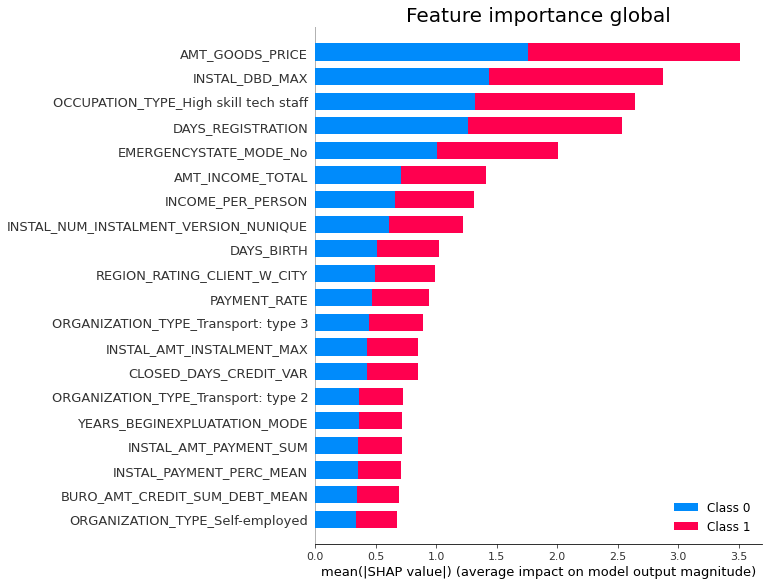

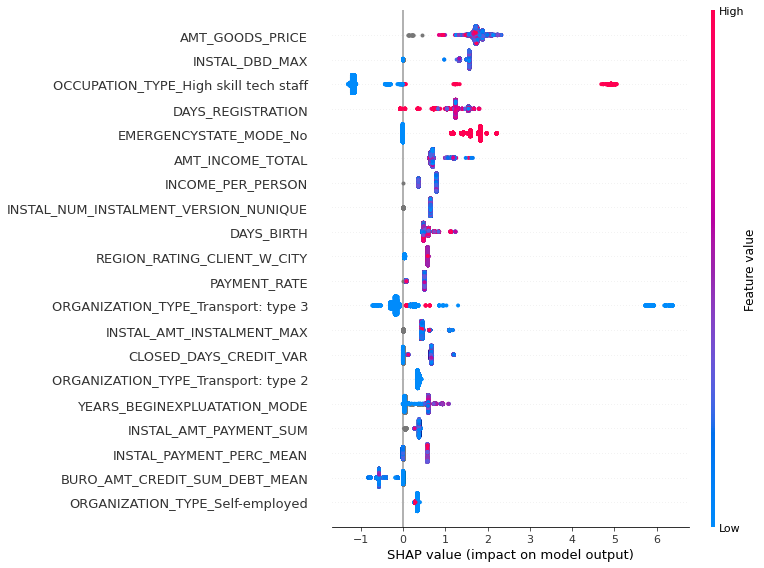

In [18]:
feature_importance_global_graphics(inputs, lgbm_shap_values)

## Graphiques

In [19]:
import seaborn as sns

In [20]:
def predict_all_data(data, preprocess, model):
    data_copy = data.copy()
    data_customer_preprocess = preprocess.transform(data_copy)
    y_pred = model.predict(data_customer_preprocess).tolist()
    y_prob = model.predict_proba(data_customer_preprocess).tolist()
    data_copy['predict'] = y_pred
    data_copy['list_of_proba'] = y_prob
    return data_copy

In [22]:
data_predict = predict_all_data(inputs, preprocessor, lgbm_model)
data_predict.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: 

In [23]:
discrete_variables = sorted(inputs.loc[:, inputs.nunique() < 10].columns.tolist())
continuous_variables = sorted(inputs.loc[:, inputs.nunique() >= 10].columns.tolist())
all_variables = sorted(continuous_variables + discrete_variables)

In [80]:
def predict_class_and_proba_customer(data, id_, preprocess, model):
    data_id_customer = data.loc[id_].to_frame().T
    data_customer_preprocess = preprocess.transform(data_id_customer)
    y_pred = model.predict(data_customer_preprocess)[0]
    y_prob = model.predict_proba(data_customer_preprocess)[0].tolist()
    if y_pred == 0:
        return "Prêt accordé" + " ->  Probabilité:" + f"{y_prob[0]}"
    else:
        return "Prêt Refusé" + " ->  Probabilité:" + f"{y_prob[1]}"


def feature_importance_local_graphics(id_, top_n_features):
    plt.title("Feature importance local", size=20)
    plt.xlabel("Effect - SHAP value- Prediction value", size=12)
    index_id_ = list_of_ids_in_order.index(id_)
    shap.plots._waterfall.waterfall_legacy(lgbm_explainer.expected_value[1], lgbm_shap_values[0][index_id_],
                                           features=inputs.loc[id_], max_display=top_n_features)
    plt.show()
    return

def boxplot_by_feature(df, feature_name):
    fig1 = plt.figure(figsize=(10, 8))
    plt.title("Représentation schématique des quartiles, médiane et moyenne", size=15)
    sns.boxplot(data=df[[feature_name]], showfliers=False, showmeans=True)
    fig1.show()
    fig2 = plt.figure(figsize=(10, 8))
    plt.title("Séparation entre Prêt accordé et Prêt refusé", size=15)
    sns.boxplot(x='predict', y=feature_name, showfliers=False, showmeans=True, data=df)
    fig2.show()
    return fig1, fig2

def barplot_by_feature(df, feature_name):
    plt.title("Répartition des valeurs et Séparation entre Prêt accordé et Prêt refusé", size=15)
    df = df.copy()
    df['iniatialize'] = 1
    df = df[[feature_name, 'predict', 'iniatialize']].groupby([feature_name, 'predict']).count().reset_index()
    sns.barplot(x=df[feature_name], y=df.iniatialize, hue=df.predict)
    plt.xticks(rotation=0)
    plt.show()
    return

def box_or_bar_plot(df, feature_name, id_):
    if feature_name in continuous_variables:
        boxplot_by_feature(df, feature_name)
        print('Value: ', df.loc[id_][feature_name])
    else:
        barplot_by_feature(df, feature_name)
        print('Value: ', df.loc[id_][feature_name])

## Select a proba treshold

In [74]:
def extract_proba(x, i):
    return x[i]

In [34]:
list_of_ids_in_order = inputs.index.tolist()

In [35]:
data_predict_1 = data_predict[data_predict.predict == 1]
data_predict_1['proba'] = data_predict_1.list_of_proba.apply(extract_proba, i=1)
list_of_worst_customer_ids = data_predict_1[data_predict_1.proba > 0.95].head(10).index.tolist()

data_predict_0 = data_predict[data_predict.predict == 0]
data_predict_0['proba'] = data_predict_0.list_of_proba.apply(extract_proba, i=0)
list_of_best_customer_ids = data_predict_0[data_predict_0.proba > 0.95].head(10).index.tolist()

In [36]:
user_id = 100003

In [37]:
predict_class_and_proba_customer(data=inputs, id_=user_id, preprocess=preprocessor, model=lgbm_model)

'Prêt accordé ->  Probabilité:0.9850780546876488'

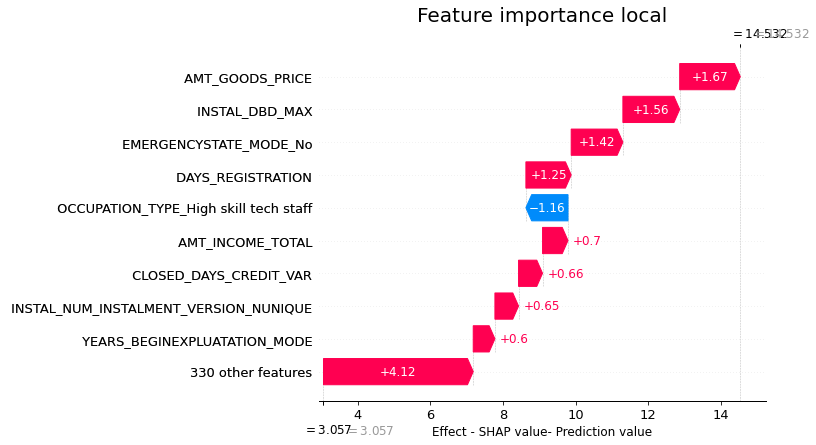

In [58]:
feature_importance_local_graphics(id_=user_id, top_n_features=10)

In [81]:
user_feature = 'AMT_GOODS_PRICE'

Value:  1129500.0


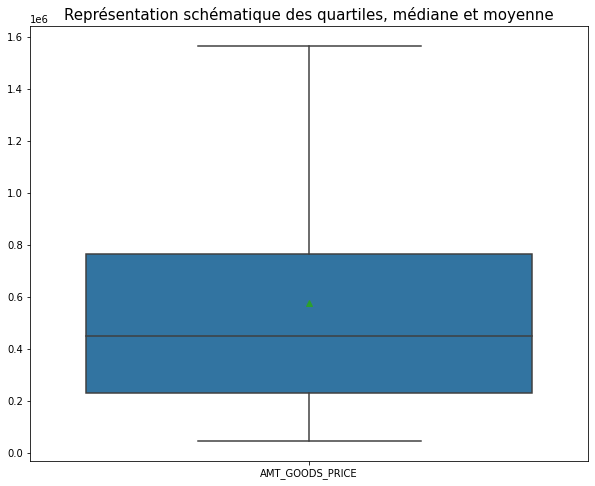

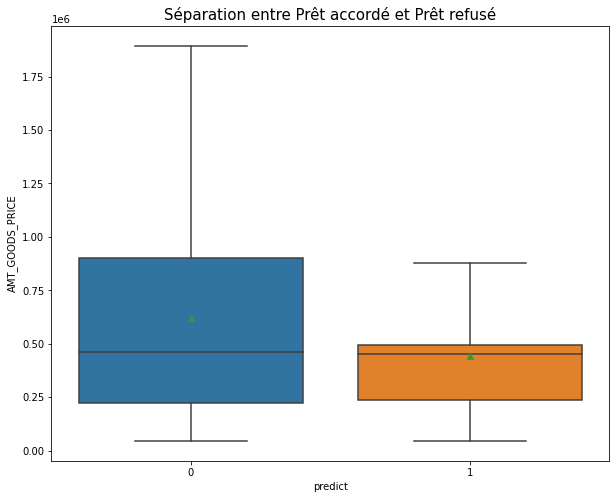

In [82]:
box_or_bar_plot(df=data_predict, feature_name=user_feature, id_=user_id)

## Clean Description

In [48]:
def load_and_clean_description():
    df = pd.read_csv('input/HomeCredit_columns_description.csv', index_col=0)
    df.sort_values(by='Row', inplace=True)
    df = df[['Row', 'Description']]
    df.drop_duplicates(inplace=True)
    df.drop([179, 141, 176, 145, 150, 173, 126, 178, 174, 197, 152, 181, 185, 183, 155, 184, 125], inplace=True)
    return df

In [49]:
hc_col_desc = load_and_clean_description()
hc_col_desc

,Row,Description
12,AMT_ANNUITY,Loan annuity
180,AMT_APPLICATION,For how much credit did client ask on the prev...
156,AMT_BALANCE,Balance during the month of previous credit
11,AMT_CREDIT,Credit amount of the loan
157,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
...,...,...
77,YEARS_BEGINEXPLUATATION_MEDI,Normalized information about building where th...
63,YEARS_BEGINEXPLUATATION_MODE,Normalized information about building where th...
50,YEARS_BUILD_AVG,Normalized information about building where th...
78,YEARS_BUILD_MEDI,Normalized information about building where th...


In [50]:
# hc_col_desc.to_csv('home_credit_feature_description.csv', index=False)

In [51]:
def print_description(df_description, feature_name):
    print(hc_col_desc[hc_col_desc.Row == feature_name].Description.values[0])

In [52]:
query = 'AMT_GOODS_PRICE'
print_description(df_description=hc_col_desc, feature_name=query)

For consumer loans it is the price of the goods for which the loan is given


## Nouvelles variables
### Par le calcul
- DAYS_EMPLOYED_PERC = DAYS_EMPLOYED / DAYS_BIRTH
- INCOME_CREDIT_PERC = AMT_INCOME_TOTAL / AMT_CREDIT
- INCOME_PER_PERSON = AMT_INCOME_TOTAL / CNT_FAM_MEMBERS
- ANNUITY_INCOME_PERC = AMT_ANNUITY/ AMT_INCOME_TOTAL
- PAYMENT_RATE = AMT_ANNUITY / AMT_CREDIT

- PAYMENT_PERC = AMT_PAYMENT / AMT_INSTALMENT (Percentage paid in each installment (amount paid and installment value))
- PAYMENT_DIFF = AMT_INSTALMENT - AMT_PAYMENT (Difference paid in each installment (amount paid and installment value))
- DPD = DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT (Days past due)
- DBD = DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT (days before due)

### Minimum, Maximum, Moyenne, Vaiance, Somme (Ajout suffixe)
- Ajout de min, max, mean, var, sum en suffixe pour certaines variables

### Ajout préfixe selon les données d'où est extraite la variable
- BURO_,
- ACTIVE_ (Crédit activé)
- CLOSED_ (Crédit fermé)
- POS_ ( (point of sales) and cash loans) et POS_COUNT (cash)
- INSTAL_ et INSTAL_COUNT
- CC_ et CC_COUNT (carte de crédit)